In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cmath
from scipy.linalg import circulant

import os 
os.chdir('/Users/miguel/Documents/22-23/wimmer_lab/')
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Serif"
})

In [2]:
def circ_dist(x, y):
    return np.angle(np.exp(x * 1j) / np.exp(y * 1j))

def transfer_func(x):
    # input-output function for all cells, as in Rubin et al 2015
    return 0.04 * (np.maximum(x, np.zeros_like(x)) + 1) ** 2

In [3]:
class SSN:
    def __init__(self):
        parameters = np.array(['batchsize',       # number of trials that are simulated in one loop                     
                               'dt',              # simulation time step (s)
                               'dt_rate',         # results' resolution (ms)
                               'tmax',            # total time of the simulation
                               
                               # default neuron and network parameters
                               'NE',              # number of excitatory neurons
                               'NI',              # number of inhibitory neurons
                               'tauE',            # time constant of rate equation for excitatory neurons
                               'tauI',            # time constant of rate equation for inhibitory neurons
                               'tauF',            # factor to convert into firing rate
                               
                               'sigma_ori',       # parameter defining the width of Gaussian connection profiles
                               'GEE',             # strength of excitation to excitatory neurons
                               'GIE',             # strength of excitation to inhibitory neurons
                               'GEI',             # strength of inhibition to excitatory neurons
                               'GII',             # strength of inhibition to inhibitory neurons
                               'I0E',             # external bias current to excitatory neurons
                               'I0I',             # external bias current to inhibitory neurons
                               'tau_b',           # time constant of (noisy) background inputs (s)
                               
                               # default stimulus parameters
                               'tcue',            # cue (stimulus) period (s)
                               'sigma_stim_E',    # parameter defining the width of stimulus input
                               'sigma_stim_I',    # parameter defining the width of stimulus input
                               'I0_stim_E',       # strength of external stimulus
                               'I1_stim_E',       # strength of external stimulus
                               'I0_stim_I',       # strength of external stimulus
                               'I1_stim_I',       # strength of external stimulus
                               'th_stim'          # stimulus direction (rad)
                              ])  
        values = np.zeros(parameters.shape)
        self.params = dict(zip(parameters, values))
        
        
    def prep(self, **kwargs):
        self.params.update(kwargs.items())
        
        # ---------------------------------------------------
        # Set up network, depending on the default parameters
        # ---------------------------------------------------
    
        self.params.update({'N': self.params.get('NE') + self.params.get('NI')})    # total number of neurons

        # Set up connectivity 
        self.params.update({'theta': np.arange(self.params.get('NE')) / self.params.get('NE') * 2 * np.pi - np.pi})

        v = np.round(np.exp(np.round(- circ_dist(self.params.get('theta'), np.pi) ** 2, 4) / np.round(2 * self.params.get('sigma_ori') ** 2, 4)), 4)

        self.params.update({'W': np.vstack([np.hstack([self.params.get('GEE') / self.params.get('NE') * circulant(v), 
                                                  - self.params.get('GEI') / self.params.get('NI') * circulant(v)]),
                                            np.hstack([self.params.get('GIE') / self.params.get('NE') * circulant(v), 
                                                  - self.params.get('GII') / self.params.get('NI') * circulant(v)])])
                           })

        # the W matrix is structured like this:
        # [strength of E <- E connections       strength of E <- I connections]
        # [strength of I <- E connections       strength of I <- I connections]

        # set up external bias currents
        self.params.update({'I0': np.concatenate([self.params.get('I0E') * np.ones(self.params.get('NE')), self.params.get('I0I') * np.ones(self.params.get('NI'))])})

        # set up time constants
        self.params.update({'tau': np.concatenate([self.params.get('tauE') * np.ones(self.params.get('NE')), self.params.get('tauI') * np.ones(self.params.get('NI'))])})

        # indeces of excitatory and inhibitory neurons 
        self.params.update({'idxE': np.arange(self.params.get('NE')), 
                            'idxI': np.arange(self.params.get('NI'), self.params.get('N'))})

        # initialize simulation
        self.params.update({'t': np.arange(0, self.params.get('tmax') + self.params.get('dt'), self.params.get('dt')),
                            'r': np.zeros(self.params.get('N'))
                           })

        # stimulus 
        stimulus_E = np.exp(- circ_dist(self.params.get('theta'), self.params.get('th_stim')) ** 2 / (2 * self.params.get('sigma_stim_E') ** 2))
        stimulus_I = np.exp(- circ_dist(self.params.get('theta'), self.params.get('th_stim')) ** 2 / (2 * self.params.get('sigma_stim_I') ** 2))

        self.params.update({'stimulus': np.concatenate([(self.params.get('I0_stim_E') + self.params.get('I1_stim_E')) * stimulus_E,
                                                        (self.params.get('I0_stim_I') + self.params.get('I1_stim_I')) * stimulus_I])})

        
    def run(self):    
        # SSN network à la Rubin et al. Neuron 2015
        t = self.params.get('t')
        
        # use the same initial conditions in each trial 
        r = self.params.get('r')
        delta_t = np.round(self.params.get('dt_rate') / self.params.get('dt'))
        R = np.zeros((self.params.get('batchsize'), self.params.get('N'), round(t.shape[0] / delta_t)))

        W_trans = self.params.get('W').T    # does not make a difference if W is symmetric, but otherwise it does

        # Simulation loop
        i_R = 0
        for i in range(t.size):

            # current input to each population 
            I = r @ W_trans + self.params.get('I0')

            # stimulus input 
            if t[i] >= self.params.get('tcue')[0] and t[i] < self.params.get('tcue')[1]:
                I = I + self.params.get('stimulus')

            # integration with time-step params.get('dt')
            r = r + (- r + 1 / self.params.get('tauF') * transfer_func(I)) * self.params.get('dt') / self.params.get('tau')

            if (i-1) % delta_t == 0:
                R[:, :, i_R] = r
                i_R = i_R + 1
        return R

In [4]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=180, NI=180, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(-90))

In [5]:
# run the simulations (100 different values of the input strength)

R = np.zeros((100, ssn.params.get('N'), ssn.params.get('t').size))
for i in range(100):
    ssn.prep(I1_stim_E=i, I1_stim_I=i)
    R[i, :, :] = ssn.run()
    
min_r = np.min(abs(ssn.params.get('th_stim') - ssn.params.get('theta')))
i_pref = np.where(ssn.params.get('th_stim') - ssn.params.get('theta') == min_r)

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)

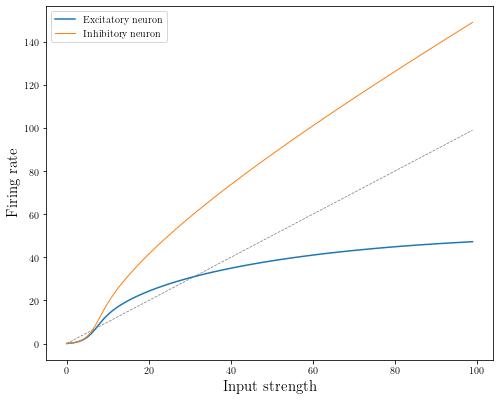

In [6]:
fig = plt.figure(figsize=(8, 6.5))

plt.plot(np.arange(100), np.squeeze(R[:, i_pref, my_t]), zorder=2)
plt.plot(np.arange(100), np.squeeze(R[:, ssn.params.get('NE') + i_pref[0][0], my_t]), lw=1, zorder=3)
plt.plot(np.arange(100), np.arange(100), '--', lw=0.75, c='grey', zorder=1)

plt.xlabel('Input strength', fontsize=15)
plt.ylabel('Firing rate', fontsize=15)
plt.legend(['Excitatory neuron', 'Inhibitory neuron'])

#plt.savefig('')
plt.show()

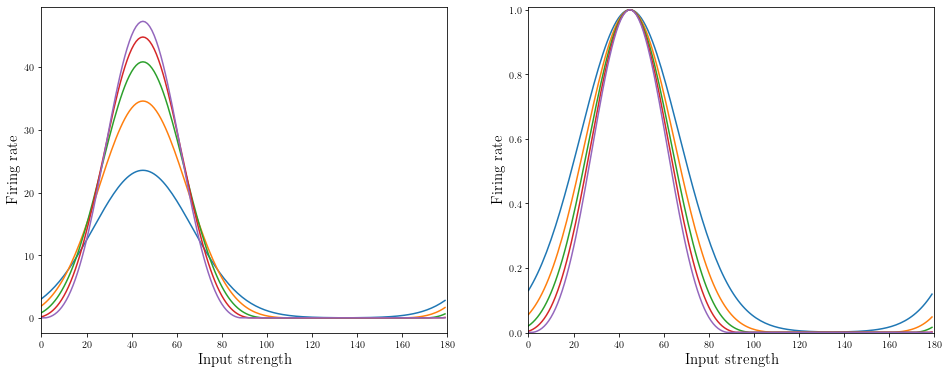

In [7]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, 180), np.squeeze(R[19:100:20, ssn.params.get('idxE'), my_t]).T)
ax1.set_xlabel('Input strength', fontsize=15)
ax1.set_ylabel('Firing rate', fontsize=15)
ax1.set_xlim([0,180])

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, 180), (np.squeeze(R[19:100:20, ssn.params.get('idxE'), my_t]) / np.max(R[19:100:20, ssn.params.get('idxE'), my_t], axis=2)).T)
ax2.set_xlabel('Input strength', fontsize=15)
ax2.set_ylabel('Firing rate', fontsize=15)
ax2.set_xlim([0,180])
ax2.set_ylim([0,1.01])

#plt.savefig('')
plt.show()

##### Figure 1G. Sublinear response summation for multiple stimuli

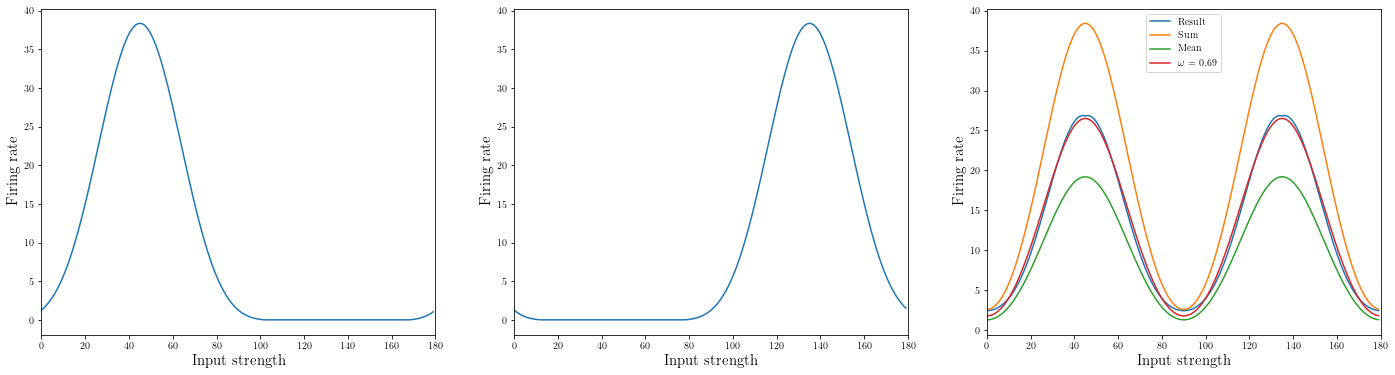

In [8]:
R = np.zeros((3, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=50, I1_stim_I=50, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=50, I1_stim_I=50, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# two stimuli, at th_stim = -90 and th_stim = +90
ssn.params.update({'stimulus': stim_neg90 + stim_pos90})
R[2, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)

fig = plt.figure(figsize=(24, 6))

ax1 = fig.add_subplot(131)
ax1.plot(np.arange(180), np.squeeze(R[0, ssn.params.get('idxE'), my_t]), zorder=1)
ax1.set_xlabel('Input strength', fontsize=15)
ax1.set_ylabel('Firing rate', fontsize=15)
ax1.set_xlim([0,180])

ax2 = fig.add_subplot(132)
ax2.plot(np.arange(180), np.squeeze(R[1, ssn.params.get('idxE'), my_t]), zorder=1)
ax2.set_xlabel('Input strength', fontsize=15)
ax2.set_ylabel('Firing rate', fontsize=15)
ax2.set_xlim([0,180])

ax3 = fig.add_subplot(133)
ax3.plot(np.arange(180), np.squeeze(R[2, ssn.params.get('idxE'), my_t]), zorder=1)
ax3.plot(np.arange(180), np.squeeze(R[0, ssn.params.get('idxE'), my_t]) + np.squeeze(R[1, ssn.params.get('idxE'), my_t]), zorder=1)
ax3.plot(np.arange(180), 1 / 2 * np.squeeze(R[0, ssn.params.get('idxE'), my_t]) + 1 / 2 * np.squeeze(R[1, ssn.params.get('idxE'), my_t]), zorder=1)
ax3.plot(np.arange(180), 0.69 * np.squeeze(R[0, ssn.params.get('idxE'), my_t]) + 0.69 * np.squeeze(R[1, ssn.params.get('idxE'), my_t]), zorder=1)
ax3.legend(['Result', 'Sum', 'Mean', '$\\omega$ = 0.69'])
ax3.set_xlim([0,180])

ax3.set_xlabel('Input strength', fontsize=15)
ax3.set_ylabel('Firing rate', fontsize=15)

#plt.savefig('/Users/miguel/Desktop/plot3.pdf')
plt.show()

##### Figure 1H. Increasingly winner-take-all responses for increasingly divergent contrasts of the two stimuli.

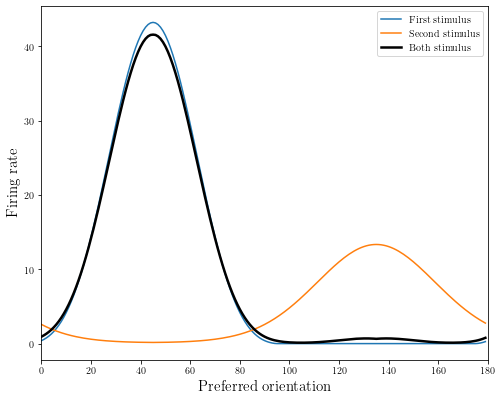

In [9]:
R = np.zeros((3, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=70, I1_stim_I=70, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# two stimuli, at th_stim = -90 and th_stim = +90
ssn.params.update({'stimulus': stim_neg90 + stim_pos90})
R[2, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)

fig = plt.figure(figsize=(8, 6.5))

plt.plot(np.arange(180), np.squeeze(R[0, ssn.params.get('idxE'), my_t]), zorder=1)
plt.plot(np.arange(180), np.squeeze(R[1, ssn.params.get('idxE'), my_t]), zorder=2)
plt.plot(np.arange(180), np.squeeze(R[2, ssn.params.get('idxE'), my_t]), c='black', lw=2.5, zorder=3)

plt.xlim([0,180])
plt.xlabel('Preferred orientation', fontsize=15)
plt.ylabel('Firing rate', fontsize=15)
plt.legend(['First stimulus', 'Second stimulus', 'Both stimulus'])

#plt.savefig('/Users/miguel/Desktop/plot4.pdf')
plt.show()

##### Set width, strength and location of top-down attention input to excitatory and inhibitory neurons

In [10]:
I_att_E, sigma_att_E = 1, np.deg2rad(2 * 30)
I_att_I, sigma_att_I = 0.6, np.deg2rad(2 * 60)
th_att = np.deg2rad(+90)

#### Combination of a strong stimulus with a weak top-down signal

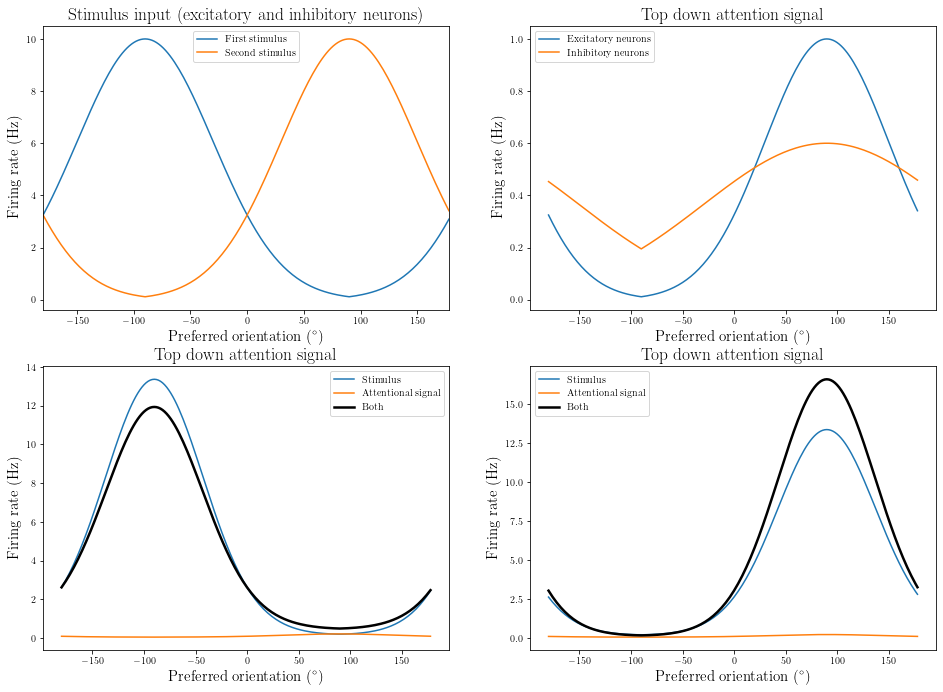

In [11]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=180, NI=180, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(-90))
ssn.run()
R = np.zeros((5, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att)
stim_att = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

# stimulus and top-down signal combined
ssn.params.update({'stimulus': stim_neg90 + stim_att})
R[3, :, :] = ssn.run()

ssn.params.update({'stimulus': stim_pos90 + stim_att})
R[4, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

fig = plt.figure(figsize=(16, 24))

ax1 = fig.add_subplot(421)
ax1.plot(th, stim_neg90[idxE], zorder=1)
ax1.plot(th, stim_pos90[idxE], zorder=1)
ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('Stimulus input (excitatory and inhibitory neurons)', fontsize=17.5)
ax1.legend(['First stimulus', 'Second stimulus'])
ax1.set_xlim([min(th), max(th)])

ax2 = fig.add_subplot(422)
ax2.plot(th, stim_att[idxE], zorder=1)
ax2.plot(th, stim_att[idxI], zorder=1)
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('Top down attention signal', fontsize=17.5)
ax2.legend(['Excitatory neurons', 'Inhibitory neurons'])

ax3 = fig.add_subplot(423)
ax3.plot(th, np.squeeze(R[0, ssn.params.get('idxE'), my_t]), zorder=1)
ax3.plot(th, np.squeeze(R[2, ssn.params.get('idxE'), my_t]), zorder=2)
ax3.plot(th, np.squeeze(R[3, ssn.params.get('idxE'), my_t]), c='black', lw=2.5, zorder=3)
ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)
ax3.set_title('Top down attention signal', fontsize=17.5)
ax3.legend(['Stimulus', 'Attentional signal', 'Both'])

ax4 = fig.add_subplot(424)
ax4.plot(th, np.squeeze(R[1, ssn.params.get('idxE'), my_t]), zorder=1)
ax4.plot(th, np.squeeze(R[2, ssn.params.get('idxE'), my_t]), zorder=2)
ax4.plot(th, np.squeeze(R[4, ssn.params.get('idxE'), my_t]), c='black', lw=2.5, zorder=3)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Firing rate (Hz)', fontsize=15)
ax4.set_title('Top down attention signal', fontsize=17.5)
ax4.legend(['Stimulus', 'Attentional signal', 'Both'])

plt.show()

##### Set width, strength and location of top-down attention input to excitatory and inhibitory neurons

In [12]:
I_att_E, sigma_att_E = 1, np.deg2rad(2 * 10)
I_att_I, sigma_att_I = 0.6, np.deg2rad(2 * 20)
th_att = np.deg2rad(+90)

In [13]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=180, NI=180, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),    
         I0_stim_E=0., I1_stim_E=50, I0_stim_I=0., I1_stim_I=50, th_stim=np.deg2rad(-90))

th_stims = np.arange(-180, 180, 1)

In [14]:
# tuning curves, "no attention" condition
R_no = np.zeros((400, th_stims.shape[0]))

for i in range(th_stims.shape[0]):
    ssn.prep(NE=200, NI=200, I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(th_stims[i]))
    r = ssn.run();
    min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
    my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
    R_no[:, i]  = np.squeeze(r[:, :, my_t])

In [15]:
# tuning curves, "attention in" condition (attention signal at 90 degrees)
R_in = np.zeros((400, th_stims.shape[0]))

ssn.prep(NE=200, NI=200, I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att)
stim_att = ssn.params.get('stimulus')
    
for i in range(th_stims.shape[0]):
    ssn.prep(NE=200, NI=200, I1_stim_E=10, I1_stim_I=10, sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60), th_stim=np.deg2rad(th_stims[i]))
    ssn.params.update({'stimulus': ssn.params.get('stimulus') + stim_att})
    r = ssn.run();
    min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
    my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
    R_in[:, i]  = np.squeeze(r[:, :, my_t])

In [16]:
# tuning curves, "att out" condition (attention signal at -90 degree)
R_out = np.zeros((400, th_stims.shape[0]))

ssn.prep(NE=200, NI=200, I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=-th_att)
stim_att = ssn.params.get('stimulus')
    
for i in range(th_stims.shape[0]):
    ssn.prep(NE=200, NI=200, I1_stim_E=10, I1_stim_I=10, sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60), th_stim=np.deg2rad(th_stims[i]))
    ssn.params.update({'stimulus': ssn.params.get('stimulus') + stim_att})
    r = ssn.run();
    min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
    my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
    R_out[:, i]  = np.squeeze(r[:, :, my_t])

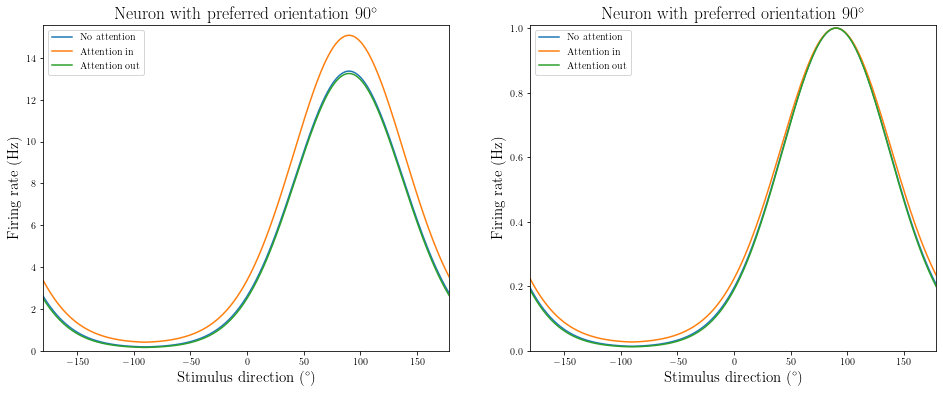

In [17]:
th = np.rad2deg(ssn.params.get('theta'))
my_neuron = np.where(th == 90)
idxE = ssn.params.get('idxE')

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(th_stims, np.squeeze(R_no[my_neuron]), zorder=1)
ax1.plot(th_stims, np.squeeze(R_in[my_neuron]), zorder=1)
ax1.plot(th_stims, np.squeeze(R_out[my_neuron]), zorder=1)
ax1.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('Neuron with preferred orientation $90^\circ$', fontsize=17.5)
ax1.legend(['No attention', 'Attention in', 'Attention out'])
ax1.set_xlim([min(th), max(th)])
ax1.set_ylim([0, max(max(np.squeeze(R_no[my_neuron])), max(np.squeeze(R_in[my_neuron])), max(np.squeeze(R_out[my_neuron]))) + 0.5])

ax2 = fig.add_subplot(122)
ax2.plot(th_stims, np.squeeze(R_no[my_neuron]) / max(np.squeeze(R_no[my_neuron])), zorder=1)
ax2.plot(th_stims, np.squeeze(R_in[my_neuron]) / max(np.squeeze(R_in[my_neuron])), zorder=1)
ax2.plot(th_stims, np.squeeze(R_out[my_neuron]) / max(np.squeeze(R_out[my_neuron])), zorder=1)
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('Neuron with preferred orientation $90^\circ$', fontsize=17.5)
ax2.legend(['No attention', 'Attention in', 'Attention out'])
ax2.set_xlim([min(th), max(th)])
ax2.set_ylim([0, 1+0.01])

plt.show()

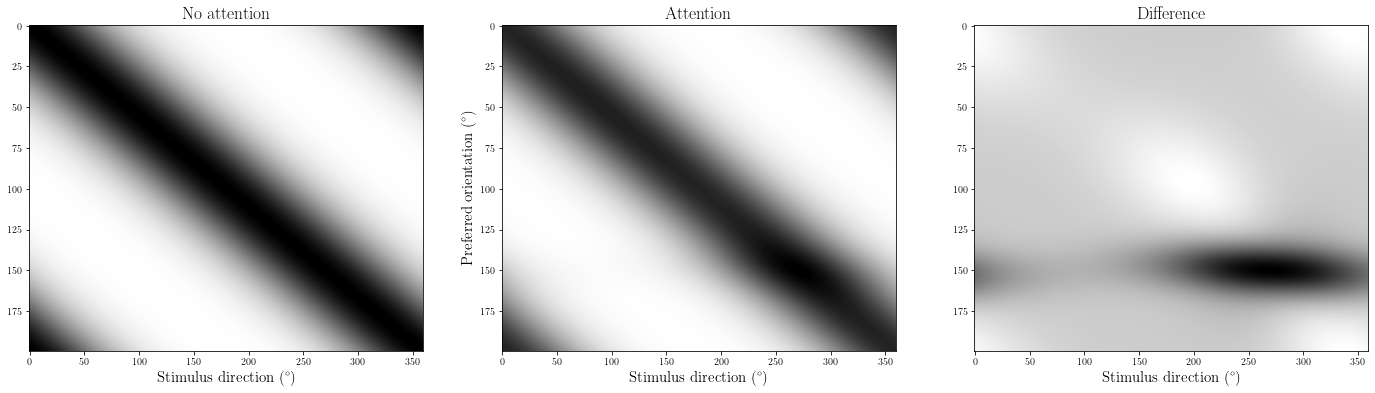

In [18]:
fig = plt.figure(figsize=(24, 6))

ax1 = fig.add_subplot(131)
ax1.imshow(R_no[idxE,:], cmap='gray_r', aspect='auto')
ax1.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_title('No attention', fontsize=17.5)

ax2 = fig.add_subplot(132)
ax2.imshow(R_in[idxE,:], cmap='gray_r', aspect='auto')
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_title('Attention', fontsize=17.5)

ax3 = fig.add_subplot(133)
ax3.imshow(R_in[idxE,:] - R_no[idxE,:], cmap='gray_r', aspect='auto')
ax3.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_title('Difference', fontsize=17.5)

plt.show()

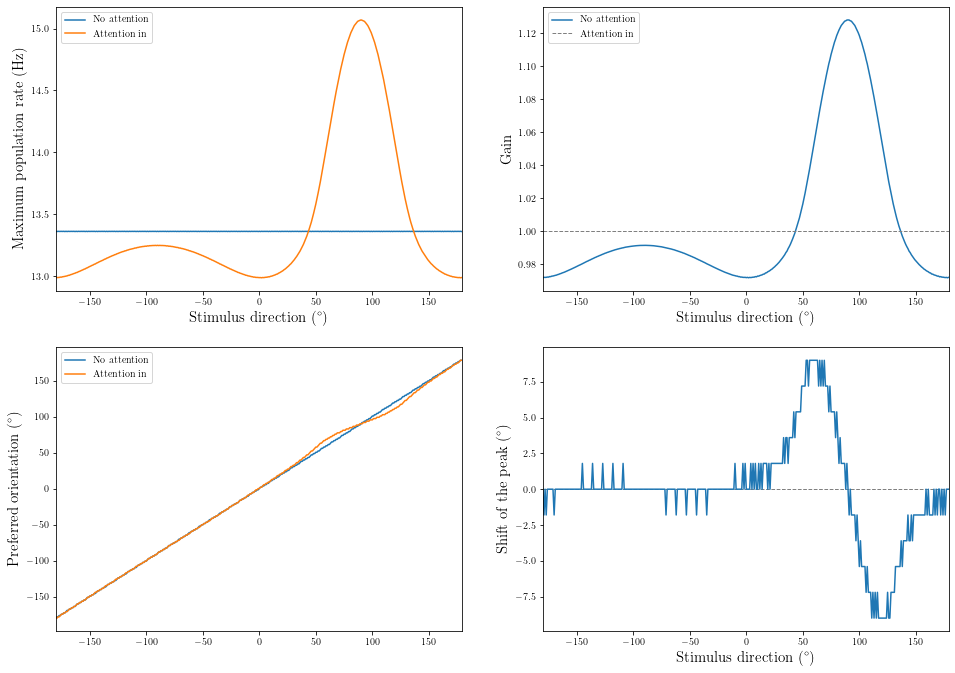

In [19]:
i_max = np.where(R_no[idxE,:] == np.max(R_no[idxE,:], axis=0)[np.newaxis,:])
theta_max_no = ssn.params.get('theta')[i_max[0]]
i_max = np.where(R_in[idxE,:] == np.max(R_in[idxE,:], axis=0)[np.newaxis,:])
theta_max_in = ssn.params.get('theta')[i_max[0]]


fig = plt.figure(figsize=(16, 24))

ax1 = fig.add_subplot(421)
ax1.plot(th_stims, np.max(R_no[idxE,:], axis=0), zorder=1)
ax1.plot(th_stims, np.max(R_in[idxE,:], axis=0), zorder=1)
ax1.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax1.set_ylabel('Maximum population rate (Hz)', fontsize=15)
ax1.legend(['No attention', 'Attention in'])
ax1.set_xlim([min(th_stims), max(th_stims)])

ax2 = fig.add_subplot(422)
ax2.plot(th_stims, np.max(R_in[idxE,:], axis=0) / np.max(R_no[idxE,:], axis=0), zorder=1)
ax2.plot(th_stims, np.repeat(1, th_stims.shape[0]), '--', lw=1, c='grey', zorder=1)
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Gain', fontsize=15)
ax2.legend(['No attention', 'Attention in'])
ax2.set_xlim([min(th_stims), max(th_stims)])

ax3 = fig.add_subplot(423)
ax3.plot(th_stims, np.rad2deg(theta_max_no), zorder=1)
ax3.plot(th_stims, np.rad2deg(theta_max_in), zorder=1)
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax3.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.legend(['No attention', 'Attention in'])
ax3.set_xlim([min(th_stims), max(th_stims)])

ax4 = fig.add_subplot(424)
ax4.plot(th_stims, np.rad2deg(circ_dist(theta_max_in, theta_max_no)), zorder=2)
ax4.plot(th_stims, np.repeat(0, th_stims.shape[0]), '--', lw=1, c='grey', zorder=1)
ax4.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax4.set_ylabel('Shift of the peak $(^\circ)$', fontsize=15)
ax4.set_xlim([min(th_stims), max(th_stims)])

plt.show()